# ASL Fingerspelling Recognition

Created by Patrick Adams and Gail Goveas

###Downloading Data from Cloud

In [2]:
#!pip install google-cloud-storage
!pip install keras-tcn
!pip install keras_tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [3]:
#importing and authenticating google colab
from google.cloud import storage
from google.colab import auth
auth.authenticate_user()

In [4]:
#creating a client object for Google Cloud storage
client = storage.Client()

#creating a reference to the Google Cloud bucket
bucket = client.get_bucket('asl_fingerspelling_project_bucket-1')
blob = bucket.blob('asl-fingerspelling/train.csv')
blob2 = bucket.blob('asl-fingerspelling/train_landmarks/1019715464.parquet')
blob3 = bucket.blob('asl-fingerspelling/character_to_prediction_index.json')

In [5]:
#downloading the data to a local file
blob.download_to_filename('train.csv')
blob2.download_to_filename('train_landmark1.parquet')
blob3.download_to_filename('character_to_prediction.json')

###Installing Packages

In [6]:
#importing packages
import pandas as pd
import pyarrow.parquet as pq
import json
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Input

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tcn import TCN

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tcn import TCN
from keras_tuner import RandomSearch




###Loading and Analysing Data

In [7]:
# Loading and exploring the metadata
metadata_df = pd.read_csv('train.csv')
print(metadata_df.head())
print(f"shape of metadata is: {metadata_df.shape}")

                              path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  
0               3 creekhouse  
1            scales/kuhaylah  
2        1383 william lanier  
3          988 franklin lane  
4  6920 northeast 661st road  
shape of metadata is: (67208, 5)


The dataset 67,208 records distributed across five distinctive columns.
The features are as follows:

*  ***path***- Shows where the landmark file is stored.
*  ***file_id***- A unique identifier for the data file.
*  ***participant_id*** A unique identifier for the data contributor.
*  ***sequence_id*** - A unique identifier for the landmark sequence. Each data file may contain many sequences.

In the "train.csv" dataset, there is also a label called ***phrase***. The train and test datasets contain randomly generated addresses, phone numbers, and urls derived from components of real addresses/phone numbers/urls.


In [8]:
#Loading the landmark data which is a parquet file
df_landmark = pd.read_parquet('train_landmark1.parquet', engine='pyarrow')
print(df_landmark.head())
print(f"shape of landmark dataset is: {df_landmark.shape}")

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1975433633   0.582115  0.591430  0.498995  0.595773  ...        -0.253687   
1975433633   0.582197  0.591687  0.497613  0.596104  ...              NaN   
1975433633   0.581191  0.591550  0.497113  0.596477  ...        -0.233556   
1975433633   0.581652  0.591728  0.496759  0.596573  ...        -0.190909   
1975433633   0.581873  0.592467  

In [9]:
# Selecting a random row from the metadata
random_row = metadata_df.sample(n=1, random_state = 10)

# Extracting the 'sequence_id' and 'phrase' from the random row
sequence_id, phrase = random_row.iloc[0][['sequence_id', 'phrase']]
print(f"sequence_id: {sequence_id}, phrase: {phrase}")

# Extracting rows from the landmark file where the index matches 'sequence_id'
sample_sequence_df = df_landmark.loc[sequence_id]
print(sample_sequence_df.head())
print(f"shape of {phrase} is: {sample_sequence_df.shape}")

sequence_id: 1990366432, phrase: erik hamilton
             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1990366432       0  0.605239  0.593421  0.596282  0.580097  0.592252   
1990366432       1  0.603645  0.592110  0.595200  0.579088  0.590954   
1990366432       2  0.603877  0.592069  0.595029  0.579474  0.591040   
1990366432       3  0.604464  0.592974  0.595711  0.580374  0.592028   
1990366432       4  0.608290  0.596224  0.598583  0.583649  0.595389   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1990366432   0.592052  0.592877  0.500375  0.591588  ...        -0.104486   
1990366432   0.590844  0.591982  0.500396  0.590895  ...        -0.077800   
1990366432   0.591081  0.592483  0.501297  0.591556  ...        -0.061390   
1990366432   0.592118  0.593550  0.501846  0.592731  ...       

This particular phrase 'erik hamilton' contains 142 entries and 1630 columns

In [10]:
#Parsing the JSON file into a Python Object

# Opening and reading the JSON file
with open('character_to_prediction.json', 'r') as file:
    char_to_pred = json.load(file)

print(char_to_pred)#This is the dictionary we use to encode categorical data to numerical data

{' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}


In [11]:
#Merging the data to add the label to the landmark data
df = df_landmark.merge(metadata_df[['sequence_id', 'phrase']], how='left', left_index=True, right_on='sequence_id')
print(df.head())
print(f"shape of merged data is: {df.shape}")

       frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  x_face_5  \
30259      0  0.578892  0.578482  0.582906  0.572686  0.579030  0.582115   
30259      1  0.577563  0.578528  0.582916  0.572760  0.579090  0.582197   
30259      2  0.576181  0.576949  0.581346  0.572293  0.577725  0.581191   
30259      3  0.575575  0.577569  0.581769  0.572443  0.578289  0.581652   
30259      4  0.577907  0.577628  0.582295  0.572930  0.578345  0.581873   

       x_face_6  x_face_7  x_face_8  ...  z_right_hand_13  z_right_hand_14  \
30259  0.591430  0.498995  0.595773  ...        -0.123892        -0.195255   
30259  0.591687  0.497613  0.596104  ...              NaN              NaN   
30259  0.591550  0.497113  0.596477  ...        -0.116145        -0.179053   
30259  0.591728  0.496759  0.596573  ...        -0.093956        -0.149982   
30259  0.592467  0.498170  0.597383  ...              NaN              NaN   

       z_right_hand_15  z_right_hand_16  z_right_hand_17  z_right_hand_18 

In [12]:
#setting sequence_id as index in the combined dataframe
df.set_index('sequence_id', inplace=True)
print(df.head())

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1975433633       0  0.578892  0.578482  0.582906  0.572686  0.579030   
1975433633       1  0.577563  0.578528  0.582916  0.572760  0.579090   
1975433633       2  0.576181  0.576949  0.581346  0.572293  0.577725   
1975433633       3  0.575575  0.577569  0.581769  0.572443  0.578289   
1975433633       4  0.577907  0.577628  0.582295  0.572930  0.578345   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_12  \
sequence_id                                          ...                    
1975433633   0.582115  0.591430  0.498995  0.595773  ...        -0.291687   
1975433633   0.582197  0.591687  0.497613  0.596104  ...              NaN   
1975433633   0.581191  0.591550  0.497113  0.596477  ...        -0.267114   
1975433633   0.581652  0.591728  0.496759  0.596573  ...        -0.218471   
1975433633   0.581873  0.592467  

###Data Preprocessing

####Filling NaN values

In [23]:
#Checking if the dataset has NaN values
df.isna()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20,phrase
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1975433633,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008677531,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2008677531,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2008677531,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
#Filling the NaN values with 0
df = df.fillna(0)

In [25]:
#Confirming there are no NaN values present
df.isna().sum()

frame              0
x_face_0           0
x_face_1           0
x_face_2           0
x_face_3           0
                  ..
z_right_hand_17    0
z_right_hand_18    0
z_right_hand_19    0
z_right_hand_20    0
phrase             0
Length: 1631, dtype: int64

####Normalising Data

In [26]:
# Initializing StandardScaler
scaler = StandardScaler()

# Creating a list to hold the normalized features for each sequence
normalized_features = []

# Grouping the data by 'sequence_id' index
for sequence_id, group in df.groupby(level=0):

    # Sorting the group by the 'frame' column to ensure the correct temporal order
    group_sorted = group.sort_values(by='frame')

    # Extracting features from the sorted group, excluding the 'frame' and 'phrase' columns
    features = group_sorted.drop(columns=['frame', 'phrase'], errors='ignore').values

    # Normalizing the features
    normalized_features.append(scaler.fit_transform(features))

####Padding Features

In [27]:
# Determining the maximum sequence length
max_feature_sequence_length = max(len(sequence) for sequence in normalized_features)
print(f"Maximum sequence length of features is: {max_feature_sequence_length}")

# Padding the feature sequences
padded_features = pad_sequences(normalized_features, maxlen=max_feature_sequence_length, padding='post', dtype='float32')


Maximum sequence length of features is: 751


####Padding and Encoding Labels

In [28]:
# Grouping by 'sequence_id' and selecting the last 'phrase' of each group
labels_df = df.groupby(level=0)['phrase'].last()
print(labels_df.head())

sequence_id
1975433633                +95-335-395
1975473601         bugs.launchpad.net
1975502450    mirandasphysiosteps.com
1975521182          5 endeavor circle
1975541698               +44-4560-846
Name: phrase, dtype: object


In [29]:
# Resetting the index
labels_df = labels_df.reset_index()
# Converting phrases to sequence of integers using char_to_pred
label_sequences = [[char_to_pred[char] for char in phrase] for phrase in labels_df['phrase']]

In [30]:
# Calculating the maximum length of the sequences
max_sequence_length = max(len(sequence) for sequence in label_sequences)
print(f"Maximum sequence length of phrase is: {max_sequence_length}")

# Padding the sequence labels
padded_label_sequences = pad_sequences(label_sequences, maxlen=max_sequence_length, padding='post')
print(f"Shape of the padded label sequences is: {padded_label_sequences.shape}")

Maximum sequence length of phrase is: 30
Shape of the padded label sequences is: (998, 30)


In [31]:
#Accounting for padding by adding 1 to the length
num_classes = len(char_to_pred) + 1
print(f"The number of classes is: {num_classes}")

#One-hot encoding the last label of each sequence for a many-to-one setup
last_label_indices = padded_label_sequences[:, -1]  # This gets the last label index for each sequence
one_hot_labels = to_categorical(last_label_indices, num_classes=num_classes)

# Checking the shape of the one-hot encoded labels
print(f"Shape of the One-Hot Encoded labels is: {one_hot_labels.shape}")


The number of classes is: 60
Shape of the One-Hot Encoded labels is: (998, 60)


In [32]:
print("Shape of padded_features:", padded_features.shape)
print("Shape of one_hot_labels:", one_hot_labels.shape)

Shape of padded_features: (998, 751, 1629)
Shape of one_hot_labels: (998, 60)


###Splitting Data

In [33]:
# Splitting into training and remaining datas
X_train, X_temp, y_train, y_temp = train_test_split(padded_features, one_hot_labels, test_size=0.4, random_state=42)

# Split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


###Data Modeling

####LSTM Model

In [34]:
# Defining the LSTM model
lstm_model = Sequential()

# Adding the first LSTM layer
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(751, 1629)))

# Adding a dropout layer for regularization
lstm_model.add(Dropout(0.2))

# Adding another LSTM layer, return_sequences is False to return only the last output for the sequence
lstm_model.add(LSTM(units=128))

# Adding another dropout layer
lstm_model.add(Dropout(0.2))

# Output layer with 'softmax' activation, units equal to the number of classes (60)
lstm_model.add(Dense(units=60, activation='softmax'))

In [35]:
# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
#lstm_model_checkpoint= ModelCheckpoint('lstm_model.h5', monitor='val_loss', save_best_only=True)

# Compiling the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Printing the model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 751, 128)          900096    
                                                                 
 dropout (Dropout)           (None, 751, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 60)                7740      
                                                                 
Total params: 1039420 (3.97 MB)
Trainable params: 1039420 (3.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
#Training the model
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose = 2)

Epoch 1/10
19/19 - 45s - loss: 2.3209 - accuracy: 0.8980 - val_loss: 2.6182 - val_accuracy: 0.6150 - 45s/epoch - 2s/step
Epoch 2/10
19/19 - 38s - loss: 1.1073 - accuracy: 0.8278 - val_loss: 0.2342 - val_accuracy: 0.9750 - 38s/epoch - 2s/step
Epoch 3/10
19/19 - 37s - loss: 0.2276 - accuracy: 0.9749 - val_loss: 0.2117 - val_accuracy: 0.9750 - 37s/epoch - 2s/step
Epoch 4/10
19/19 - 38s - loss: 0.1926 - accuracy: 0.9749 - val_loss: 0.2140 - val_accuracy: 0.9750 - 38s/epoch - 2s/step
Epoch 5/10
19/19 - 37s - loss: 0.1917 - accuracy: 0.9749 - val_loss: 0.2181 - val_accuracy: 0.9750 - 37s/epoch - 2s/step
Epoch 6/10
19/19 - 37s - loss: 0.1925 - accuracy: 0.9749 - val_loss: 0.2238 - val_accuracy: 0.9750 - 37s/epoch - 2s/step
Epoch 7/10
19/19 - 37s - loss: 0.1894 - accuracy: 0.9749 - val_loss: 0.2296 - val_accuracy: 0.9750 - 37s/epoch - 2s/step
Epoch 8/10
19/19 - 37s - loss: 0.1834 - accuracy: 0.9749 - val_loss: 0.2323 - val_accuracy: 0.9750 - 37s/epoch - 2s/step
Epoch 9/10
19/19 - 37s - loss: 0

In [37]:
# Generating predictions for the test set
y_pred_lstm = lstm_model.predict(X_test)

# Convert predictions to class labels
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy_lstm = accuracy_score(y_test_classes, y_pred_lstm_classes)

print(f"Accuracy: {test_accuracy_lstm}")

7/7 [==============================] - 6s 650ms/step
Accuracy: 0.985


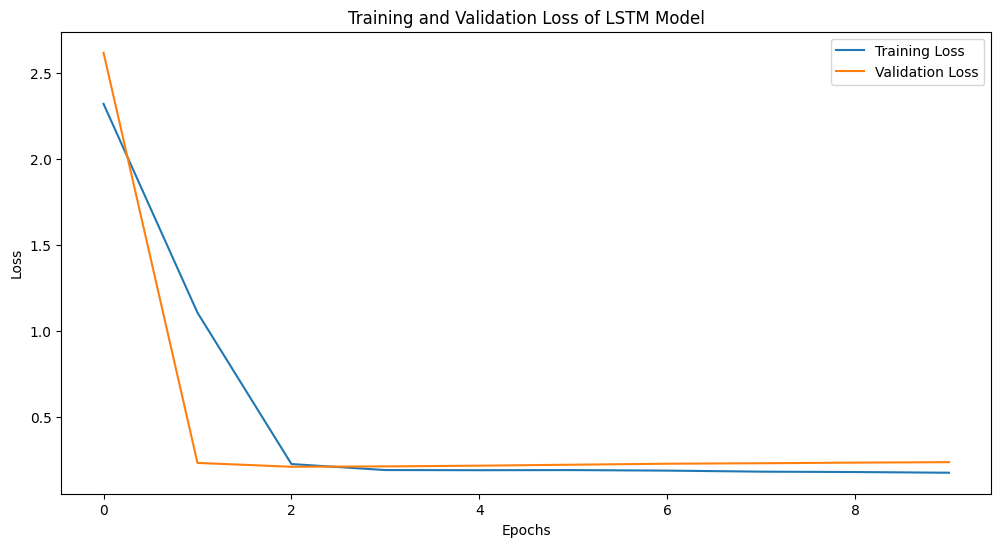

In [39]:
# Assuming 'history' is the output from the model.fit() method
history_dict_lstm = history_lstm.history

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history_dict_lstm['loss'], label='Training Loss')
plt.plot(history_dict_lstm['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


####GRU Model

In [40]:
#GRU Model Architecture
def create_gru_model():
    model = Sequential()
    model.add(GRU(units=128, return_sequences=True, input_shape=(751, 1629)))
    model.add(GRU(units=128))
    model.add(Dense(60, activation='softmax'))  # 60 classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Creating the model
gru_model = create_gru_model()

# Model summary
gru_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 751, 128)          675456    
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 60)                7740      
                                                                 
Total params: 782268 (2.98 MB)
Trainable params: 782268 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
#gru_model_checkpoint = ModelCheckpoint('gru_model.h5', monitor='val_loss', save_best_only=True)

#Compiling the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training the model
history_gru = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose = 2)

Epoch 1/10
19/19 - 35s - loss: 2.3308 - accuracy: 0.9749 - val_loss: 0.3273 - val_accuracy: 0.9750 - 35s/epoch - 2s/step
Epoch 2/10
19/19 - 28s - loss: 0.3538 - accuracy: 0.9749 - val_loss: 0.3243 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 3/10
19/19 - 27s - loss: 0.3114 - accuracy: 0.9749 - val_loss: 0.2835 - val_accuracy: 0.9750 - 27s/epoch - 1s/step
Epoch 4/10
19/19 - 28s - loss: 0.2541 - accuracy: 0.9749 - val_loss: 0.2245 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 5/10
19/19 - 28s - loss: 0.2036 - accuracy: 0.9749 - val_loss: 0.2063 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 6/10
19/19 - 28s - loss: 0.1855 - accuracy: 0.9749 - val_loss: 0.2128 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 7/10
19/19 - 28s - loss: 0.1827 - accuracy: 0.9749 - val_loss: 0.2207 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 8/10
19/19 - 28s - loss: 0.1809 - accuracy: 0.9749 - val_loss: 0.2256 - val_accuracy: 0.9750 - 28s/epoch - 1s/step
Epoch 9/10
19/19 - 28s - loss: 0

In [42]:
# Generating predictions for the test set
y_pred_gru = gru_model.predict(X_test)

# Convert predictions to class labels
y_pred_gru_classes = np.argmax(y_pred_gru, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy_gru = accuracy_score(y_test_classes, y_pred_gru_classes)

print(f"Accuracy: {test_accuracy_gru}")

7/7 [==============================] - 5s 425ms/step
Accuracy: 0.985


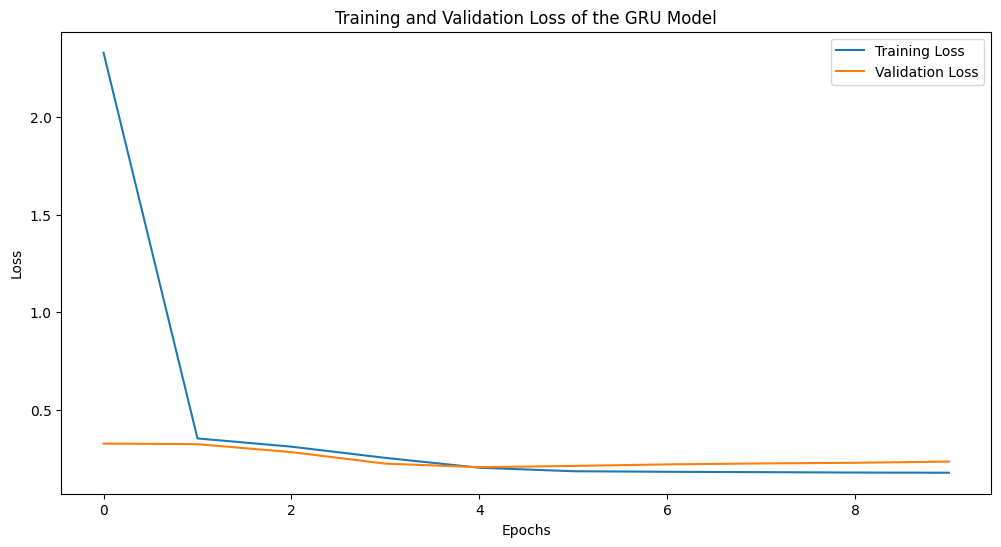

In [43]:
history_dict_gru = history_gru.history

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history_dict_gru['loss'], label='Training Loss')
plt.plot(history_dict_gru['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the GRU Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


####TCN Model

In [44]:
#Definig TCN Model Architecture
def create_tcn_model():
    input_shape = (751, 1629)  # Sequence length x number of features
    num_classes = 60  # Number of output classes

    input_layer = Input(shape=input_shape)
    tcn_layer = TCN(nb_filters=32, kernel_size=3, nb_stacks=2, dilations=[1, 2, 4, 8, 16], padding='causal', return_sequences=False)(input_layer)
    output_layer = Dense(num_classes, activation='softmax')(tcn_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
tcn_model = create_tcn_model()

# Model summary to verify the architecture
tcn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 751, 1629)]       0         
                                                                 
 tcn (TCN)                   (None, 32)                267552    
                                                                 
 dense_2 (Dense)             (None, 60)                1980      
                                                                 
Total params: 269532 (1.03 MB)
Trainable params: 269532 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# Compile the model
tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_tcn = tcn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose = 2)


Epoch 1/10
10/10 - 17s - loss: 1.9601 - accuracy: 0.9716 - val_loss: 0.8642 - val_accuracy: 0.9750 - 17s/epoch - 2s/step
Epoch 2/10
10/10 - 11s - loss: 0.8530 - accuracy: 0.9749 - val_loss: 0.4245 - val_accuracy: 0.9750 - 11s/epoch - 1s/step
Epoch 3/10
10/10 - 10s - loss: 0.3448 - accuracy: 0.9749 - val_loss: 0.2961 - val_accuracy: 0.9750 - 10s/epoch - 979ms/step
Epoch 4/10
10/10 - 10s - loss: 0.2595 - accuracy: 0.9749 - val_loss: 0.2850 - val_accuracy: 0.9750 - 10s/epoch - 992ms/step
Epoch 5/10
10/10 - 10s - loss: 0.2398 - accuracy: 0.9749 - val_loss: 0.2518 - val_accuracy: 0.9750 - 10s/epoch - 965ms/step
Epoch 6/10
10/10 - 10s - loss: 0.2263 - accuracy: 0.9749 - val_loss: 0.2415 - val_accuracy: 0.9750 - 10s/epoch - 951ms/step
Epoch 7/10
10/10 - 10s - loss: 0.2146 - accuracy: 0.9749 - val_loss: 0.2353 - val_accuracy: 0.9750 - 10s/epoch - 985ms/step
Epoch 8/10
10/10 - 10s - loss: 0.2087 - accuracy: 0.9749 - val_loss: 0.2330 - val_accuracy: 0.9750 - 10s/epoch - 976ms/step
Epoch 9/10
10/

In [46]:
# Generating predictions for the test set
y_pred_tcn = tcn_model.predict(X_test)

# Convert predictions to class labels
y_pred_tcn_classes = np.argmax(y_pred_tcn, axis=1)

# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy_tcn = accuracy_score(y_test_classes, y_pred_tcn_classes)

print(f"Accuracy: {test_accuracy_tcn}")

7/7 [==============================] - 2s 151ms/step
Accuracy: 0.985


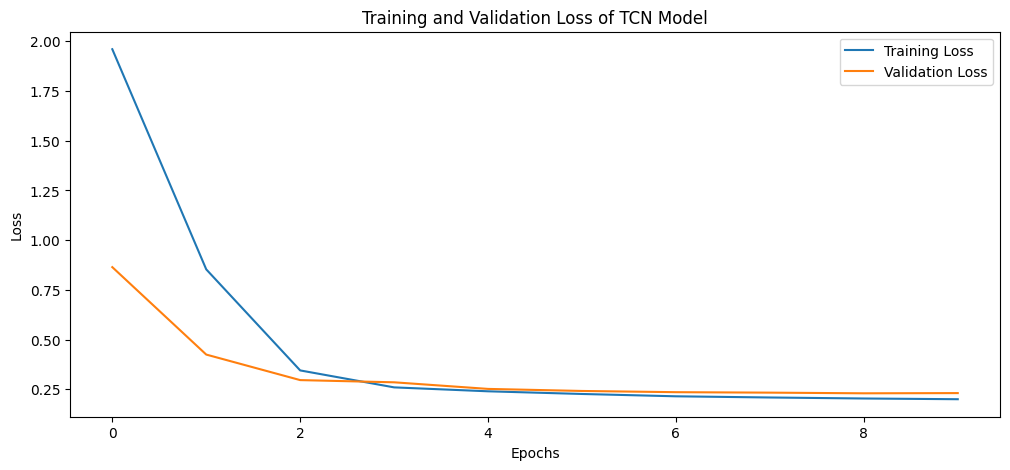

In [47]:
# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.plot(history_tcn.history['loss'], label='Training Loss')
plt.plot(history_tcn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of TCN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

####Comparing Model performance

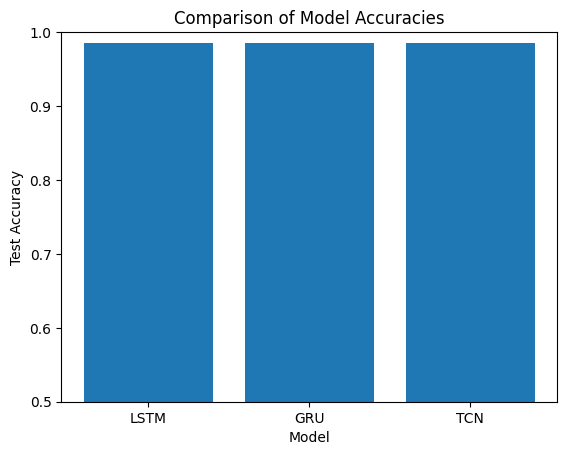

In [48]:
#Comparing Test Accuracies

# Data for plotting
model_names = ['LSTM', 'GRU', 'TCN']
accuracies = [test_accuracy_lstm, test_accuracy_gru, test_accuracy_tcn]

plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0.5, 1])  # Set the y-axis limits
plt.show()


In [49]:
# Generate predictions
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)
tcn_predictions = tcn_model.predict(X_test)

7/7 [==============================] - 1s 144ms/step


In [50]:
# Calculate precision for each model
precision_lstm = precision_score(y_test.argmax(axis=1), lstm_predictions.argmax(axis=1), average='weighted')
precision_gru = precision_score(y_test.argmax(axis=1), gru_predictions.argmax(axis=1), average='weighted')
precision_tcn = precision_score(y_test.argmax(axis=1), tcn_predictions.argmax(axis=1), average='weighted')

print(f"LSTM Precision: {precision_lstm}")
print(f"GRU Precision: {precision_gru}")
print(f"TCN Precision: {precision_tcn}")

LSTM Precision: 0.9702249999999999
GRU Precision: 0.9702249999999999
TCN Precision: 0.9702249999999999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
#Calculting Recall_Score

recall_lstm = recall_score(y_test.argmax(axis=1), lstm_predictions.argmax(axis=1), average='weighted')
recall_gru = recall_score(y_test.argmax(axis=1), gru_predictions.argmax(axis=1), average='weighted')
recall_tcn = recall_score(y_test.argmax(axis=1), tcn_predictions.argmax(axis=1), average='weighted')

print(f"LSTM Recall: {recall_lstm}")
print(f"GRU Recall: {recall_gru}")
print(f"TCN Recall: {recall_tcn}")


LSTM Recall: 0.985
GRU Recall: 0.985
TCN Recall: 0.985


In [52]:
#Calculating F1 Score

f1_lstm = f1_score(y_test.argmax(axis=1), lstm_predictions.argmax(axis=1), average='weighted')
f1_gru = f1_score(y_test.argmax(axis=1), gru_predictions.argmax(axis=1), average='weighted')
f1_tcn = f1_score(y_test.argmax(axis=1), tcn_predictions.argmax(axis=1), average='weighted')

print(f"LSTM F1 Score: {f1_lstm}")
print(f"GRU F1 Score: {f1_gru}")
print(f"TCN F1 Score: {f1_tcn}")


LSTM F1 Score: 0.9775566750629724
GRU F1 Score: 0.9775566750629724
TCN F1 Score: 0.9775566750629724


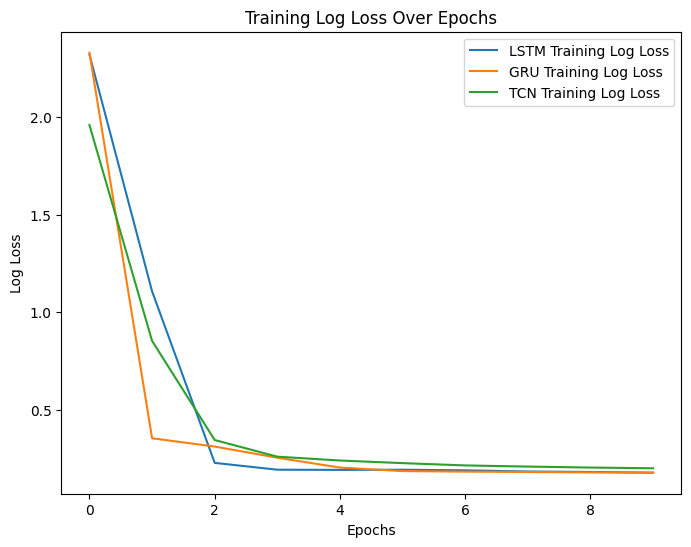

In [53]:
# Plotting log loss values for each epoch in the training history
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='LSTM Training Log Loss')
plt.plot(history_gru.history['loss'], label='GRU Training Log Loss')
plt.plot(history_tcn.history['loss'], label='TCN Training Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training Log Loss Over Epochs')
plt.legend()
plt.show()


###Improving TCN Accuracy

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
#Implementing Earky Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [55]:
#Adding a Learning Rate Scheduler
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)


In [56]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tcn import TCN
from kerastuner.tuners import RandomSearch

def build_model(hp):
    input_shape = (751, 1629)  # Sequence length x number of features
    num_classes = 60  # Number of output classes

    input_layer = Input(shape=input_shape)

    # Allowing the tuner to choose the number of filters and kernel size
    tcn_layer = TCN(
        nb_filters=hp.Int('nb_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
        nb_stacks=hp.Int('nb_stacks', min_value=1, max_value=3, step=1),
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        use_skip_connections=True,
        dropout_rate=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1),
        return_sequences=False
    )(input_layer)

    output_layer = Dense(num_classes, activation='softmax')(tcn_layer)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Allowing the tuner to choose the learning rate
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

<ipython-input-56-57421f5d8bfc>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [58]:
# Defining the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # The number of models to try
    executions_per_trial=1,  # The number of models to build and fit for each trial
    directory='keras_tuner',
    project_name='tcn_tuning'
)

In [59]:
# Conducting the hyperparameter tuning
tuner.search_space_summary()

# Starting the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 5 Complete [00h 03m 30s]
val_accuracy: 0.9750000238418579

Best val_accuracy So Far: 0.9750000238418579
Total elapsed time: 00h 23m 00s


In [60]:
#Displaying Results of all trials
tuner.results_summary(num_trials=len(tuner.oracle.trials))

Results summary
Results in keras_tuner/tcn_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
nb_filters: 128
kernel_size: 5
nb_stacks: 1
dropout_rate: 0.4
optimizer: rmsprop
Score: 0.9750000238418579

Trial 1 summary
Hyperparameters:
nb_filters: 96
kernel_size: 5
nb_stacks: 1
dropout_rate: 0.0
optimizer: sgd
Score: 0.9750000238418579

Trial 2 summary
Hyperparameters:
nb_filters: 96
kernel_size: 5
nb_stacks: 1
dropout_rate: 0.2
optimizer: sgd
Score: 0.9750000238418579

Trial 3 summary
Hyperparameters:
nb_filters: 64
kernel_size: 5
nb_stacks: 3
dropout_rate: 0.4
optimizer: sgd
Score: 0.9750000238418579

Trial 4 summary
Hyperparameters:
nb_filters: 64
kernel_size: 5
nb_stacks: 1
dropout_rate: 0.1
optimizer: adam
Score: 0.9750000238418579


In [64]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7af5f6fded40>


In [61]:
# Building the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Printing the model's architecture
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 751, 1629)]       0         
                                                                 
 tcn_1 (TCN)                 (None, 128)               1989760   
                                                                 
 dense_1 (Dense)             (None, 60)                7740      
                                                                 
Total params: 1997500 (7.62 MB)
Trainable params: 1997500 (7.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# Train the best model
history = model.fit(X_train, y_train, epochs= 10, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])


Epoch 1/10
19/19 [==============================] - 33s 2s/step - loss: 0.2550 - accuracy: 0.9749 - val_loss: 0.2653 - val_accuracy: 0.9750 - lr: 6.7032e-04
Epoch 2/10
19/19 [==============================] - 32s 2s/step - loss: 0.2694 - accuracy: 0.9749 - val_loss: 0.2514 - val_accuracy: 0.9750 - lr: 6.7032e-04
Epoch 3/10
19/19 [==============================] - 32s 2s/step - loss: 0.2545 - accuracy: 0.9749 - val_loss: 0.2932 - val_accuracy: 0.9750 - lr: 6.7032e-04
Epoch 4/10
19/19 [==============================] - 32s 2s/step - loss: 0.2283 - accuracy: 0.9749 - val_loss: 0.3024 - val_accuracy: 0.9750 - lr: 6.7032e-04
Epoch 5/10
19/19 [==============================] - 32s 2s/step - loss: 0.2594 - accuracy: 0.9749 - val_loss: 0.2747 - val_accuracy: 0.9750 - lr: 6.7032e-04


In [67]:
# Evaluate the best model
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

7/7 [==============================] - 4s 489ms/step - loss: 0.1130 - accuracy: 0.9850
[test loss, test accuracy]: [0.11300069093704224, 0.9850000143051147]
